## Todos 
1. Correct CDR3 kmerization. 

## Requirements

In [104]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random
import pandas as pd
import r2python

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [105]:
NULL_token = 0
SOS_token = 1
EOS_token = 2


class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: 'NULL', 1: 'SOS', 2: 'EOS'}
        self.n_words = 2
        
    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)
    
    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words +=1
        else:
            self.word2count[word] += 1

In [106]:
# Turn a Unicode string to plain ASCII, thanks to
# http://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters


def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

In [107]:
def readLangs(lang1, lang2, reverse=False):
    print("Reading lines ...")
    
    # Read the file and split into lines
    lines = open('data/%s-%s.txt' %(lang1, lang2), encoding='utf-8').\
        read().strip().split('\n')
    
    # Split every line into pairs and normalize
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]
    
    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)
        
    return input_lang, output_lang, pairs
    
    

In [108]:
def indexesFromSentence(lang, sentence):
    indexes = [lang.word2index[word] for word in sentence.split(' ')]
    indexes.append(EOS_token)
    return indexes

def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence) 
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)

# ## check if the view is accurate 
# def tensorFromSentences(lang, sentences):
#     indexes_mat = [indexesFromSentence(lang, sentence) for sentence in sentences]
#     return torch.tensor(indexes_mat, dtype=torch.long, device=device).view(-1, 1)

def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor_mat = tensorFromSentences(output_lang, pair[1])
    prior_z_np = np.ones(length(target_tensor_mat))/length(target_tensor_mat)
    prior_z =  torch.tensor(prior_z_np, dtype=torch.long, device=device)
    return (input_tensor, target_tensor, prior_z)
# len(pairs[0])
# random.choice(pairs)


In [152]:
def readInput_cdr3b(lang, langfile):
    print("Reading %s ..." %(lang))
    
    # Read the file and split into lines
    df = pd.read_csv(langfile, "\t")

    df = df[['kmer.sentence', 'patient']]
    input_lang = Lang(lang)
    
    print("Counting words...")
    for kmerS in df['kmer.sentence']:
        input_lang.addSentence(kmerS)
        
    df['kmer.tensor'] = df['kmer.sentence'].apply(lambda x: tensorFromSentence(input_lang, x))
    
    return input_lang, df

def readInput_epitope(lang, langfile, nfold=None):
    """The module reads CDR3 and Epitopes of and create lists for each tcga patients
    output are
    cdr3s_list: list of cdr3 per common patient,
    neoantigens_list: list of Epitope per common patient,
    negative_patients: For each patient list of other patients that does not share any neoantigen with the patient

    approx schematic of the function


    # read files
    # find common paitents
    # convert to tensor
    # create list
    """
    def create_neoantigen_list_from_patient_list(patients_lists, nfold=None):
        """
        Ouput neoantigen for patients list
        """
        
        df_common = df[df['patient'].isin(patients_lists)]
        neoantigens_list = []
        for patient_inx, patient in zip(range(len(patients_lists)), patients_lists):
            neoantigen_curr = df_common[df_common['patient'] == patient]['kmer.tensor']
            neoantigens_list.append(neoantigen_curr)

        neoantigens_list = [neoantigen.values.tolist() for neoantigen in neoantigens_list]
        return neoantigens_list
    
    df = pd.read_csv(langfile, "\t")
    
    input_lang = Lang(lang)
    print("Counting words...")
    for kmerS in df['kmer.sentence']:
        input_lang.addSentence(kmerS)
        
    df['kmer.tensor'] = df['kmer.sentence'].apply(lambda x: tensorFromSentence(input_lang, x))
    common_patients = r2python.unique(df['patient'])
    if nfold is None:
        train_patients_list = common_patients
        trainData = create_neoantigen_list_from_patient_list(train_patients_list)
        testData = None
    else:
        ### this is not working
        train_patients_list = r2python.sample(common_patients, size=int((nfold - 1) * len(common_patients) / nfold))
        test_patients_list = r2python.setdiff(common_patients, train_patients_list)
        trainData = create_neoantigen_list_from_patient_list(train_patients_list)
        testData = create_neoantigen_list_from_patient_list(test_patients_list)

    dataset = {
        "trainData": trainData,
        "testData": testData
    }
    return input_lang, dataset, df

In [111]:
MAX_LENGTH = 30


In [154]:
# def format2tensorList(List):
#     # assumes that indices are in sorted order
#     tensorList = []
#     total_indices = int(List[len(List)-1][1])
#     initial_index = 1
#     for inx in range(total_indices):
#         tensorList_set = []
#         curr
        
def prepareData(cdr3b, cdr3bfile, epitope, epitopefile):
    cdr3b_lang,  df_cdr3 = readInput_cdr3b(cdr3b, cdr3bfile)
    print("Read %s cdr3bs " % len(df_cdr3.index))


    epitope_lang,  epitope_patient_list, df_epitope = readInput_epitope(epitope, epitopefile)
    print("Read %s epitope " % len(epitope_patient_list))
    
    
    # epitope NULL sentence
    epitope_lang.addSentence('NULL')
    epitopee_null = tensorFromSentence(epitope_lang, 'NULL')

    
        
#     for pair in epitope_n_index:
#         epitope_lang.addSentence(pair[0])  
        
#     epitope_matList = format2ListofList(epitope_lang, epitope_n_index)
#         epitope_mat_lens.addLens(pair[1])
    
#     convert epitope to list of matrices for fast indexing 
  
    print("Counted words:")
    print(cdr3b_lang.name, cdr3b_lang.n_words)
    print(epitope_lang.name, epitope_lang.n_words)
    return cdr3b_lang, epitope_lang, df_cdr3, epitope_patient_list, epitopee_null, df_epitope

cdr3b_lang, epitope_lang, df_cdr3, epitope_patient_list, epitope_null, df_epitope = prepareData('cdr3b', 'data/tcga_epitope_V2.2000.txt','eptiope', 'data/all.9mers_200.txt')
# print(random.choice(pairs))

Reading cdr3b ...
Counting words...
Read 999 cdr3bs 
Counting words...
Read 2 epitope 
Counted words:
cdr3b 3062
eptiope 5168


In [114]:
# print([random.choice(pairs) for i in range(10)])
# pairs[1:10]

## Encoder

In [115]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size
        
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        
    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1,1,-1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden
        
    def initHidden(self):
        return torch.zeros(1,1, self.hidden_size, device=device)
    

## Decoder

In [116]:
class DecoderRNN(nn.Module):
    def __init__(self,  hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, input, hidden):
        output = self.embedding(input).view(1,1,-1)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.softmax(output)
        return output, hidden
    
    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

## Attention Decoder

In [117]:
class AttnDecoderRNN(nn.Module):
    def __init__(self,  hidden_size, output_size, dropout_p =0.1, max_length = MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length
        
        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
#         self.softmax = nn.Softmax(dim=1)
        
    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)
        
#         attn_weights = self.attn(torch.cat((embedded[0], hidden[0]), 1))
#         attn_weights = F.softmax(attn_weights, dim=1)
        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                encoder_outputs.unsqueeze(0))
        
        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)
        
        output= F.relu(output)
        output, hidden = self.gru(output, hidden)
        
        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights
    
    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

## Training 

## Training the model
In this model, we are generating Epitope (X) from the CDR3b (Y). This weird convention is for traditional reason. 
So the input is CDR3B and output are Antigens. 

\begin{align}
log P(X/Y) &= \sum_{x} log P(x/Y) \\ 
            &= \sum_{x} log \sum_z P(x,z/Y) \\ 
            &= \sum_{x} log \sum_z P(z/Y) P(x/z,Y) \\
            &= \sum_{x} log \mathbf{E}_z  P(x/z,Y) 
\end{align}


### TODO : Add prior proportial to expression, mhc1 presentation, clonality of mutation 
### TODO : Add prior proportial to its clonality of CDR3  

In [118]:
teacher_forcing_ratio = 0.5


def train_set(input_tensor_list, target_tensor, input_null, prior_z, encoder, decoder, encoder_optimizer,
              decoder_optimizer, criterion, max_length=MAX_LENGTH):
    ''' The function inputs cdr3bs and antigens of a set (patient) and for probability of each cdr3b generated by
    each antigens. And  also calculate the loss'''
    encoder_hidden = encoder.initHidden()

    loss = 0

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()
#     print(len(input_tensor_list))

    inputs_num = len(input_tensor_list)
    for input_inx in range(inputs_num + 1):
#         print(len(input_tensor_list))
#         print("inx:")
#         print(input_inx)
        if input_inx > 0:
            prior_z_curr = prior_z[1]
            input_tensor = input_tensor_list[input_inx-1]
        else:
            prior_z_curr = prior_z[0]
            input_tensor = input_null

        input_length = input_tensor.size(0)
        target_length = target_tensor.size(0)
    #     print(target_length)
        encoder_outputs = torch.zeros(max_length, encoder.hidden_size,
                                      device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(
                input_tensor[ei], encoder_hidden)

            encoder_outputs[ei] = encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)

        decoder_hidden = encoder_hidden

        use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

        if use_teacher_forcing:
            for di in range(target_length):
                decoder_output, decoder_hidden, decoder_attention = decoder(
                    decoder_input, decoder_hidden, encoder_outputs)
                loss += prior_z_curr * criterion(decoder_output, target_tensor[di])
                decoder_input = target_tensor[di]  # Teacher forcing

        else:
            # Without teacher forcing: use its own predictions as the next input
            for di in range(target_length):
                decoder_output, decoder_hidden, decoder_attention = decoder(
                    decoder_input, decoder_hidden, encoder_outputs)
                topv, topi = decoder_output.topk(1)
                decoder_input = topi.squeeze().detach()  # detach from history as input

                loss += prior_z_curr * criterion(decoder_output, target_tensor[di])
                if decoder_input.item() == EOS_token:
                    break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length


In [119]:
import time
import math


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [120]:
def trainIters(encoder, decoder, n_iters, total_patients, print_every=1000, plot_every=100, learning_rate=0.01):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    training_inx = r2python.sample_int(total_patients, size=n_iters, replace=True)
#     training_pairs = [tensorsFromPair(random.choice(pairs))
#                       for i in range(n_iters)]
    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        inx_curr = training_inx[iter -1]
        input_tensor_list = epitope_patient_list['trainData'][inx_curr]
#         print(len(input_tensor_list))
#         print(input_tensor_list[0])
        target_tensor = df_cdr3['kmer.tensor'][inx_curr]
        prior_z = [0.5, 0.5/len(input_tensor_list)]  # prior of NULL distribution, uniform prior 

        loss = train_set(input_tensor_list, target_tensor, epitope_null, prior_z, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)

In [170]:
import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np


def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

## Evaluation

In [171]:
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
#         print(sentence)
        input_tensor = tensorFromSentence(cdr3b_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(epitope_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words, decoder_attentions[:di + 1]

In [172]:
def evaluateRandomly(encoder, decoder, total_patients = 3, n=10, ):
    for i in range(n):
#         pair = random.choice(pairs)
        
        training_inx = r2python.sample_int(total_patients, size=1, replace=True)
#         print(training_inx)
#         print(type(training_inx))

        inx_curr = training_inx[0]
        epitope_curr = df_epitope['kmer.sentence'][inx_curr]
        cdr3b_curr = df_cdr3['kmer.sentence'][inx_curr]
        
        print('>', cdr3b_curr)
        print('=', epitope_curr)
        output_words, attentions = evaluate(encoder, decoder, cdr3b_curr)
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

## TRAINING AND EVALUATING

0m 54s (- 2m 42s) (1 25%) 8.0369
1m 24s (- 1m 24s) (2 50%) 2.7497
1m 59s (- 0m 39s) (3 75%) 2.1054
2m 12s (- 0m 0s) (4 100%) 6.1637


<Figure size 432x288 with 0 Axes>

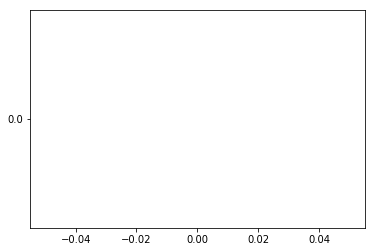

In [173]:
hidden_size = 256
encoder1 = EncoderRNN(epitope_lang.n_words, hidden_size).to(device)
attn_decoder1 = AttnDecoderRNN(hidden_size, cdr3b_lang.n_words, dropout_p=0.1).to(device)
total_patients = 3
trainIters(encoder1, attn_decoder1, n_iters=4, total_patients=total_patients, print_every=1)

In [166]:
evaluateRandomly(encoder1, attn_decoder1)

> ^^^^C ^^^CS ^^CSA ^CSAE CSAEQ SAEQG AEQGA EQGAV QGAVT GAVTG AVTGE VTGEL TGELF
= ^^^^Y ^^^YS ^^YST ^YSTK YSTKH STKHS TKHSK KHSKL HSKLY SKLY$ KLY$$ LY$$$ Y$$$$
< <EOS>

> ^^^^C ^^^CA ^^CAS ^CASS CASSL ASSLF SSLFP SLFPL LFPLA FPLAD PLADE LADEQ ADEQF
= ^^^^S ^^^ST ^^STK ^STKH STKHS TKHSK KHSKL HSKLY SKLYI KLYI$ LYI$$ YI$$$ I$$$$
< <EOS>

> ^^^^C ^^^CA ^^CAS ^CASS CASST ASSTD SSTDR STDRA TDRAY DRAYE RAYEQ AYEQY YEQYF
= ^^^^L ^^^LY ^^LYS ^LYST LYSTK YSTKH STKHS TKHSK KHSKL HSKL$ SKL$$ KL$$$ L$$$$
< <EOS>

> ^^^^C ^^^CA ^^CAS ^CASS CASST ASSTD SSTDR STDRA TDRAY DRAYE RAYEQ AYEQY YEQYF
= ^^^^L ^^^LY ^^LYS ^LYST LYSTK YSTKH STKHS TKHSK KHSKL HSKL$ SKL$$ KL$$$ L$$$$
< <EOS>

> ^^^^C ^^^CA ^^CAS ^CASS CASST ASSTD SSTDR STDRA TDRAY DRAYE RAYEQ AYEQY YEQYF
= ^^^^L ^^^LY ^^LYS ^LYST LYSTK YSTKH STKHS TKHSK KHSKL HSKL$ SKL$$ KL$$$ L$$$$
< <EOS>

> ^^^^C ^^^CA ^^CAS ^CASS CASSL ASSLF SSLFP SLFPL LFPLA FPLAD PLADE LADEQ ADEQF
= ^^^^S ^^^ST ^^STK ^STKH STKHS TKHSK KHSKL HSKLY SKLYI KLYI$ LYI$$ YI$$$ I

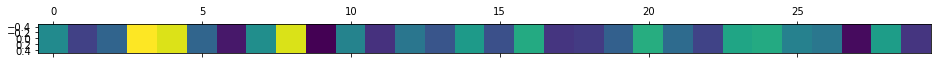

In [167]:
%matplotlib inline
output_words, attentions = evaluate(
    encoder1, attn_decoder1, "^^^^C ^^^CA ^^CAS ^CASS CASSL ASSLF SSLFP SLFPL LFPLA FPLAD PLADE LADEQ ADEQF")
plt.matshow(attentions.numpy())

input = ^^^^C ^^^CS ^^CSA ^CSAE CSAEQ SAEQG AEQGA EQGAV QGAVT GAVTG AVTGE VTGEL TGELF
output = <EOS>


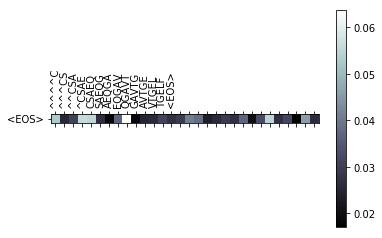

In [169]:
def showAttention(input_sentence, output_words, attentions):
    # Set up figure with colorbar
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' ') +
                       ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def evaluateAndShowAttention(input_sentence):
    output_words, attentions = evaluate(
        encoder1, attn_decoder1, input_sentence)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    showAttention(input_sentence, output_words, attentions)


evaluateAndShowAttention("^^^^C ^^^CS ^^CSA ^CSAE CSAEQ SAEQG AEQGA EQGAV QGAVT GAVTG AVTGE VTGEL TGELF")

# evaluateAndShowAttention("elle est trop petit .")

# evaluateAndShowAttention("je ne crains pas de mourir .")

# evaluateAndShowAttention("c est un jeune directeur plein de talent .")


We will create a kmer from CDR3 and antigen, with stride =1. The line will end with ".".